#Install required modules

In [1]:
!pip install -U scikit-fuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894086 sha256=5753efa5d0e06440503ebf0e7176601a15bc9e7f13242d8058f55c18b159d339
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


#Import required modules

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from sklearn.preprocessing import StandardScaler
import skfuzzy as fuzz
from copy import deepcopy
import json
import numpy as np
from scipy.linalg import fractional_matrix_power
import matplotlib.pyplot as plt

In [3]:
path = '/content/drive/MyDrive/Work/Baylor/Distributed Systems/Project'
#app = 'bearboard'
#app = 'upacharpharmacy'
#app = 'book'
app = 'book_no_extra'
if(app == 'bearboard'):
  entrypoints_texts = ['GreetingController', 'AwardController', 'UserController', 'TweetController', 'EventController','WhitelistUserController']
elif(app == 'upacharpharmacy'):
  entrypoints_texts = ['DataController', 'OrderController','CategoryController', 'DrugController','UserController','DosageFormController','SubCategoryController']
elif(app == 'autocarenepal'):
  entrypoints_texts = ['SystemController', 'VehicleController','UserController','CommentController']
elif(app == 'book'):
  entrypoints_texts = ['TicketController', 'OrderController', 'RestaurantController', 'ConsumerController', 'CourierController']
elif(app == 'book_no_extra'):
  entrypoints_texts = ['OrderController', 'RestaurantController', 'ConsumerController']

# Data Preprocessing

In [4]:
dep_file = open(path + '/' + app + '_dependency.json', 'r')
string_data = dep_file.read()
dep_file.close()
json_data = json.loads(string_data)

In [5]:
not_keys = []
for key, vals in json_data.items():
  for cls in vals:
    if(cls not in json_data.keys() and cls not in not_keys):
      not_keys.append(cls)
for key in not_keys:
  json_data[key] = []

In [6]:
cur_inx = 0
classToNode = {}
nodeToClass = {}
for class_ in json_data.keys():
  nodeToClass[cur_inx] = class_
  classToNode[class_] = cur_inx
  cur_inx += 1

In [7]:
n_nodes = len(json_data)
entrypoints = []
for entrypoint in entrypoints_texts:
  entrypoints.append(classToNode[entrypoint])
A = np.zeros((n_nodes,n_nodes))
for key, lst in json_data.items():
  for class_ in lst:
    A[classToNode[key], classToNode[class_]] = 1
C = np.zeros((n_nodes,n_nodes))
E = np.zeros((n_nodes,len(entrypoints)))
paths = []
def dfs_for_E(node, visited, graph, entrypoint_inx):
  if(visited[node] == 1):
    return
  visited[node] = 1
  for i in range(graph.shape[1]):
    if(graph[node,i] == 1):      
      if(E[i, entrypoint_inx] == 0):
        E[i, entrypoint_inx] = 1
      dfs_for_E(i, visited,graph, entrypoint_inx)
    
def dfs_for_paths(node, visited, graph, entrypoint_inx, cur_path):
  #if(visited[node] == 1):
  if(node in cur_path):
    paths[entrypoint_inx].append(cur_path)
    return  
  tmp_path = deepcopy(cur_path)
  tmp_path.append(node)
  #visited[node] = 1
  if(np.sum(graph[node]) == 0):
    paths[entrypoint_inx].append(tmp_path)
    return
  for i in range(graph.shape[1]):
    if(graph[node,i] == 1):                            
      dfs_for_paths(i, visited,graph, entrypoint_inx, tmp_path)

def getEntrypointMatrix(adj_graph, entrypoints):
  for inx, entrypoint in enumerate(entrypoints):
    visited = np.zeros(n_nodes)
    dfs_for_E(entrypoint, visited, adj_graph, inx)

def getNoOfCoEntrypoints(node1, node2, paths, entrypoints):  
  for i in range(len(entrypoints)):
    for path in paths[i]:
      if(node1 in path and node2 in path):
        if(node1 != node2):
          C[node1, node2] += 1
          C[node2, node1] += 1
        else:
          C[node1, node2] += 1
def getCoEntrypointMatrix(adj_graph, entrypoints):
  global paths
  paths = [[] for _ in range(len(entrypoints))]
  for i in range(len(entrypoints)):
    visited = np.zeros(n_nodes)
    dfs_for_paths(entrypoints[i], visited, adj_graph, i, [])
  for i in range(n_nodes):
    for j in range(n_nodes):
      getNoOfCoEntrypoints(i,j,paths, entrypoints)


In [8]:
getEntrypointMatrix(A, entrypoints)
getCoEntrypointMatrix(A, entrypoints)
for i in range(n_nodes):
  A[i,i] = 1
D = np.zeros((n_nodes, n_nodes))
for i in range(n_nodes):
  for j in range(n_nodes):
    D[i,i] += A[i,j] 
D_half_norm = fractional_matrix_power(D, -0.5)
X = np.concatenate((E,C), axis=1)
X = D_half_norm.dot(A).dot(D_half_norm).dot(X)

#Define variational autoencoder

In [9]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, A, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.A = A
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.architecture_loss_tracker = keras.metrics.Mean(
            name="architecture_loss"
        )

    def call(self, inputs):
      mean, log_var, x = self.encoder(inputs)
      x = self.decoder(x)
      return x

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.architecture_loss_tracker
        ]
    def predict(self, data):
       z_mean, z_log_var, z = self.encoder(data)
       output = self.decoder(z)
       return output
       
    def train_step(self, data):        
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            #reconstruction_loss = tf.reduce_mean(
            #    tf.reduce_sum(
            #        keras.losses.mean_absolute_error(data, reconstruction), axis=(1, 2)
            #    )
            #)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data-reconstruction), axis=(1)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            architecture_loss = tf.reduce_mean(tf.square(self.A - tf.matmul(z,z,transpose_b=True)))
            total_loss = reconstruction_loss + kl_loss + architecture_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.architecture_loss_tracker.update_state(architecture_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "architecture_loss": self.architecture_loss_tracker.result()
        }

#Define hyperparameters

In [10]:
#For VAE
nFeatures = X.shape[1]
nEmbeddings = 2
nEpochs = 8000
learningRate = 0.001
optimizer = Adam(learningRate)
batchSize = X.shape[0]


#Obtain and preprocess data

In [11]:
scaler = StandardScaler()
scaledX = scaler.fit_transform(X)

#Define VAE's architecture

In [12]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

input_encoder = Input(nFeatures)
nNeurons = nFeatures // 2
x = Dense(nNeurons, activation='tanh')(input_encoder)
nNeurons = nNeurons // 2
while(nNeurons >= nEmbeddings * 2):
  x = Dense(nNeurons, activation='tanh')(x)
  nNeurons = nNeurons // 2
z_mean = Dense(nEmbeddings, name="z_mean")(x)
z_log_var = Dense(nEmbeddings, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

input_decoder = Input(nEmbeddings)
nNeurons = nEmbeddings * 2
x = Dense(nNeurons, activation='tanh')(input_decoder)
nNeurons = nNeurons * 2
while(nNeurons <= nFeatures // 2):
  x = Dense(nNeurons, activation='tanh')(x)
  nNeurons = nNeurons * 2
recon = Dense(nFeatures)(x)
encoder = Model(input_encoder, [z_mean, z_log_var, z], name="encoder")
decoder = Model(input_decoder, recon, name="decoder")
vae = VAE(encoder, decoder, A)
vae.compile(optimizer=optimizer)
vae.built = True

#Train VAE

In [13]:
vae.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 58)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 29)           1711        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 14)           420         ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 7)            105         ['dense_1[0][0]']                
                                                                                            

In [14]:
hist = vae.fit(X, epochs = nEpochs, batch_size=batchSize, verbose =False)

In [15]:
vae.save_weights(path + '/vae_' + app + '.h5')

In [ ]:
vae.load_weights(path + '/vae_' + app + '.h5')

Text(0, 0.5, 'Architecture loss')

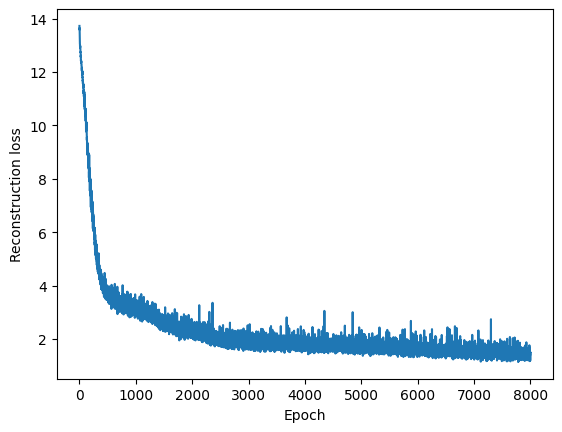

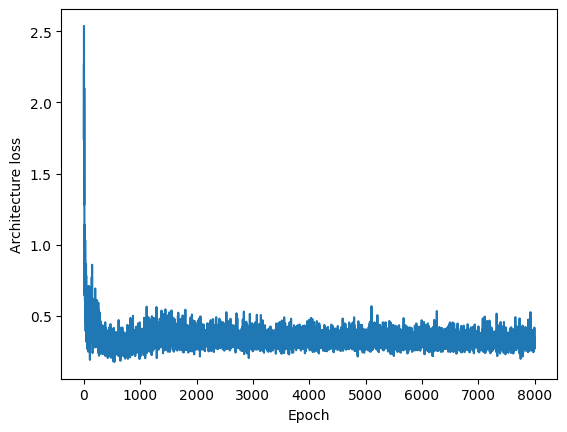

In [16]:
x_range = [i for i in range(len(hist.history['loss']))]
plt.plot(x_range, hist.history['reconstruction_loss'])
plt.xlabel('Epoch')
plt.ylabel('Reconstruction loss')
plt.figure()
plt.plot(x_range, hist.history['architecture_loss'])
plt.xlabel('Epoch')
plt.ylabel('Architecture loss')

In [17]:
_,_,Z = vae.encoder(X)


#Apply C-Means

In [24]:
maxNCenters = 20
losses = []
memberships = []
centroids = []
for nCenters in range(2,maxNCenters+1):
  cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
          Z.numpy().T, nCenters, 2, error=0.005, maxiter=1000, init=None)
  memberships.append(u)
  centroids.append(cntr)
  sse = 0
  for i in range(len(Z)):
    zLoc = np.asarray(Z[i])
    for j in range(nCenters):
      cLoc = np.asarray(cntr[j])
      sse += u[j][i] * np.sum(np.square(zLoc - cLoc))
  losses.append(sse)
  #losses.append(np.mean(np.square(d)))

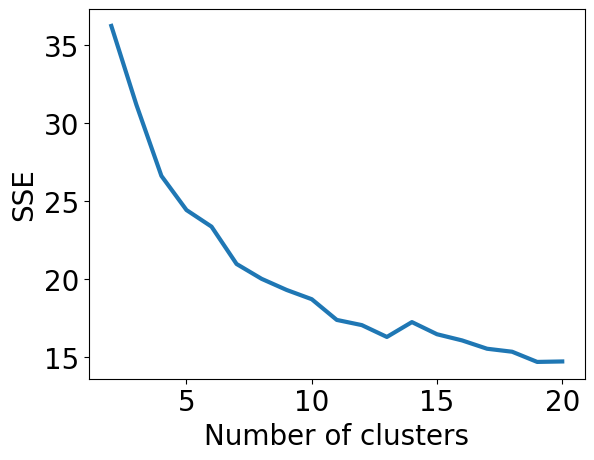

In [25]:
x_range = [i for i in range(2,maxNCenters+1)]
plt.rcParams.update({'font.size': 20, 'lines.linewidth':3})
plt.plot(x_range,losses)
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.savefig(path + '/figures/' + app + '_sse_cmeans.png', dpi=450, bbox_inches = "tight")

In [26]:
n_clusters = 7
members = [[] for i in range(n_clusters)]
members_classes = [[] for i in range(n_clusters)]
clusters = np.argmax(memberships[n_clusters-2].T, axis = 1)
for i in range(len(clusters)):
  members[clusters[i]].append(i)
  members_classes[clusters[i]].append(nodeToClass[i])

In [27]:
file = open(path + '/'+app+'_'+ str(n_clusters) + '_no_redundancy.json','w')
file.write(json.dumps(members_classes))
file.close()

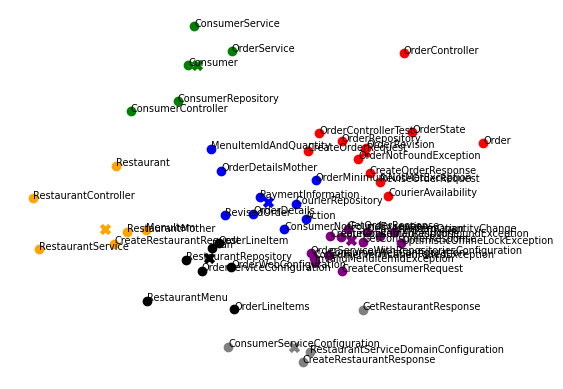

In [28]:
y = [[] for i in range(n_clusters)]
x = [[] for i in range(n_clusters)]
centroid_y = []
centroid_x = []
colors = ['red','green','blue','purple','orange', 'black', 'gray', 'pink', 'yellow', 'navy']
for i in range(n_clusters):
  for j in members[i]:
    y[i].append(Z[j][1])
    x[i].append(Z[j][0])
  centroid_y.append(centroids[n_clusters-2][i][1])
  centroid_x.append(centroids[n_clusters-2][i][0])
plt.axis('off')
plt.rcParams.update({'font.size': 7, 'lines.linewidth':3})
for i in range(n_clusters):
  plt.scatter([centroid_x[i]], [centroid_y[i]], color=colors[i],marker='x')
  plt.scatter(x[i], y[i], color=colors[i])
  for j in range(len(x[i])):
    plt.text(x[i][j], y[i][j], members_classes[i][j])
plt.savefig(path +'/figures/' + app + '_' + str(n_clusters) + '_scatter_no_redundancy.pdf', dpi=450, bbox_inches = "tight")

In [29]:
thresholds = []
i = 0.1
while(i <= 0.5):
  thresholds.append(round(i,2))
  i += 0.05
set_members = []
for threshold in thresholds:
  tmp_members = deepcopy(members)
  tmp_members_classes = deepcopy(members_classes)
  for inx, membership in enumerate(memberships[n_clusters-2]):
    for inx2, score in enumerate(membership):
      if(score >=  threshold and inx2 not in tmp_members[inx]):
        tmp_members[inx].append(inx2)
        tmp_members_classes[inx].append(nodeToClass[inx2])
  set_members.append(tmp_members_classes)
  file = open(path + '/'+app+'_' + str(n_clusters) + '_redundancy_' + str(threshold) + '.json','w')
  file.write(json.dumps(tmp_members_classes))
  file.close()

In [30]:
for lst in set_members[4]:
  print(len(lst))

12
5
9
15
6
7
5


In [31]:
for member in members:
  print(len(member))

11
5
9
13
6
7
4


In [32]:
print(memberships[0][0])

[0.09544281 0.49381522 0.64242707 0.38089176 0.51847182 0.1300645
 0.33534839 0.3135616  0.11479049 0.91847842 0.66139702 0.24977345
 0.93209864 0.51827564 0.77626738 0.06214643 0.29459325 0.53158982
 0.21618394 0.13397256 0.89353564 0.64425801 0.05716405 0.15380033
 0.81101578 0.13179096 0.160348   0.4782967  0.4606447  0.1822881
 0.5726807  0.87695233 0.12190555 0.18866157 0.11565959 0.69277449
 0.36226182 0.31044696 0.06096005 0.32067024 0.11817688 0.21817806
 0.90134955 0.81254328 0.95035433 0.79778274 0.94136235 0.05661398
 0.64726573 0.07453269 0.60983333 0.78770954 0.9345153  0.12946761
 0.09074897]
